In [285]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [286]:
clean_arr = np.loadtxt("wifi_db/clean_dataset.txt")
noisy_arr = np.loadtxt("wifi_db/noisy_dataset.txt")

In [287]:
LABEL_COL = clean_arr.shape[1] - 1 # LABEL_COL = 7
DATASET_SIZE = clean_arr.shape[0]
NUM_FOLDS = 10
labels = [1, 2, 3, 4]
noisy_arr

array([[-59., -53., -51., ..., -79., -87.,   4.],
       [-66., -53., -59., ..., -81., -79.,   1.],
       [-41., -57., -63., ..., -66., -65.,   2.],
       ...,
       [-57., -54., -56., ..., -79., -82.,   1.],
       [-56., -52., -50., ..., -85., -88.,   3.],
       [-46., -54., -47., ..., -80., -73.,   3.]])

In [288]:
class Node():
    # if node is leaf, value is used to store label
    # if node is parent, value is used to store the split_value AND
    # attr is used to store the attribute that is split on
    def __init__(self, **kwargs):
        self.label = kwargs.get('label', -1)
        self.value = kwargs.get('value', 0)
        self.attr = kwargs.get('attr', 0)
        self.left = kwargs.get('left', None)
        self.right = kwargs.get('right', None)
    
    def set_left(self, left):
        self.left = left
    
    def set_right(self, right):
        self.right = right
    
    def is_leaf(self):
        return self.left == None and self.right == None
    
    def is_parent_of_leafs(self):
        return self.is_leaf(self.left) and self.is_leaf(self.right)

    def to_string(self):
        if self.is_leaf():
            return str(int(self.label))
        else:
            return 'x_' + str(self.attr) + ' > ' + str(self.value)

In [289]:
def calc_label_instances(dataset, label):
    return np.count_nonzero(dataset[:, LABEL_COL] == label)

def find_majority_label(dataset):
    transformed = list(map(lambda x: calc_label_instances(dataset, x), labels))
    return transformed.index(max(transformed))


In [290]:
# since the log operation may return nan (eg log 0), replace all nan occurences with 0
def entropy(dataset):
    dataset_size,_ = dataset.shape
    res = np.zeros(len(labels))
    for i in range(len(labels)):
        res[i] = calc_label_instances(dataset, labels[i])
    res = res / dataset_size
    log_res = np.where(res > 0, np.log2(res), res)
    res = res * log_res
    return - np.sum(res)

In [291]:
# calculate info gain after splitting data set, assume dataset is sorted already
def remainder(dataset, split_index):
    #print("in remainder, dataset is ", dataset);
    dataset_size,_ = dataset.shape
    left_info_gain = (split_index + 1) / dataset_size * entropy(dataset[: (split_index + 1)])
    right_info_gain = (dataset_size - split_index)/dataset_size * entropy(dataset[(split_index + 1):])
    return left_info_gain + right_info_gain


def calc_info_gain(start_entropy, dataset, split_index):
    return start_entropy - remainder(dataset, split_index)

In [292]:
def get_mid(a, b):
    return (a + b) / 2

def find_split(trng_data):
    split_attribute = -1
    split_value = 0
    split_index = 0
    overall_highest_info_gain = 0
    # start_entropy calculated at the start, saving recomputation
    start_entropy = entropy(trng_data)
    dataset_size, _ = trng_data.shape
    final_sorted_dataset = trng_data
    
    # sort all data amongst columns
    # loop through each attribute
    for i in range(LABEL_COL):#
        sorted_dataset = trng_data[trng_data[:, i].argsort()]#
#         print('sorted dataset')
#         print(sorted_dataset[:, [i, LABEL_COL]]);
        current_split_value = 0
        feature_highest_info_gain = 0
        current_split_index = 0

        for j in range(dataset_size - 1):
            if sorted_dataset[j][LABEL_COL] == sorted_dataset[j + 1][LABEL_COL]: continue

            mid = get_mid(sorted_dataset[j][i], sorted_dataset[j + 1][i])
            info_gain = calc_info_gain(start_entropy, sorted_dataset, j)

            if (not math.isnan(info_gain)) and info_gain > feature_highest_info_gain:
                current_split_value = mid
                feature_highest_info_gain = info_gain
                current_split_index = j

        if overall_highest_info_gain < feature_highest_info_gain:
            overall_highest_info_gain = feature_highest_info_gain
            split_attribute = i
            split_value = current_split_value
            split_index = current_split_index
            final_sorted_dataset = sorted_dataset
#         print("Feature " + str(i) + " info gain: " + str(feature_highest_info_gain))

#     print("Start Entropy: " + str(start_entropy))
#     print("Info Gain: " + str(overall_highest_info_gain))
        
    return (split_attribute, split_value, split_index, final_sorted_dataset)

# find_split(clean_arr)

In [295]:
def decision_tree_learning(training_dataset, depth):
    first_label = training_dataset[0][LABEL_COL]
    if np.all(training_dataset[:, LABEL_COL] == first_label):
        return (Node(label=first_label), depth)
    else:
        split_attr, split_value, split_index, sorted_dataset = find_split(training_dataset)
        curr_node = Node(value=split_value, attr=split_attr)
        left_branch, left_depth = decision_tree_learning(sorted_dataset[:split_index + 1], depth + 1)
        right_branch, right_depth = decision_tree_learning(sorted_dataset[split_index + 1:], depth + 1)
        curr_node.set_left(left_branch)
        curr_node.set_right(right_branch)
        curr_node.label = find_majority_label(training_dataset)
    return (curr_node, max(left_depth, right_depth))

(root, depth) = decision_tree_learning(clean_arr, 0)
initial_depth = depth
print(depth)

13


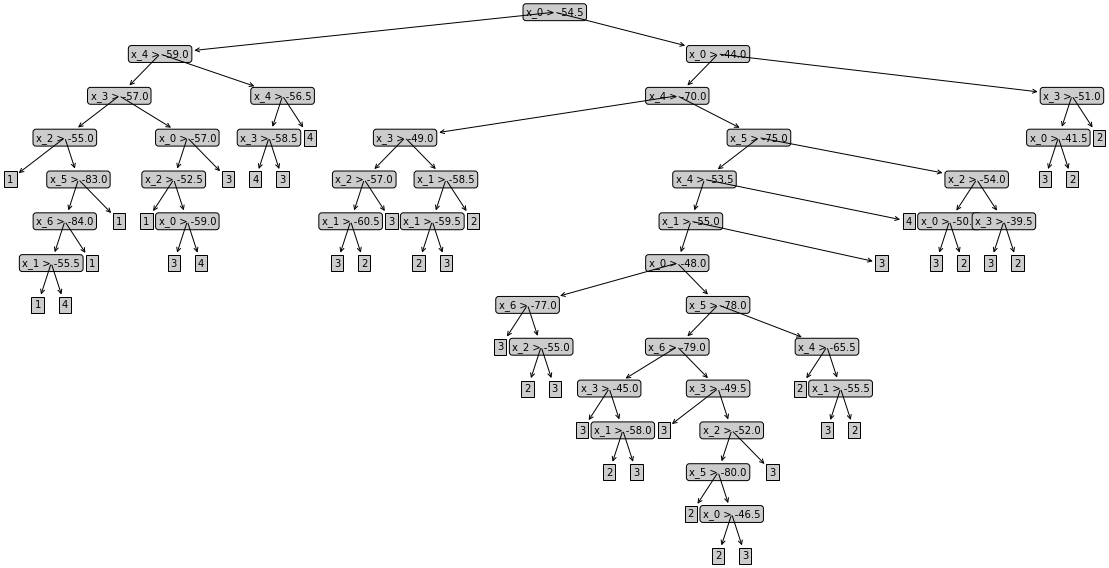

In [296]:
node_box = dict(boxstyle="round",fc="0.8")
leaf_box = dict(boxstyle="square",fc="0.8")
arrow = dict(arrowstyle="<-")
width_factor = 0.3
depth_factor = 2.5

def create_plot(root, depth):
    fig = plt.figure(1,facecolor='white')
    fig.clf()
    axprops=dict(xticks=[],yticks=[])
    create_plot.ax1=plt.subplot(111,frameon=False,**axprops)
    plot_tree.totalW=float(count_leafs(root)) * width_factor
    plot_tree.totalD=float(depth)
    plot_tree.xOff = plot_tree.totalW / 2.0
    plot_tree.yOff=1.0
    plot_tree(root,(0.5,1.0),(0.5,1.0),depth)
    plt.show()

def plot_node(text, ctr, parent, node_type):
    create_plot.ax1.annotate(text,xy=parent,xycoords='axes fraction',xytext=ctr,textcoords='axes fraction',va='center',ha='center',bbox=node_type ,arrowprops=arrow)

def plot_branch_text(ctr, parent, text):
    if text is None: return
    x=(parent[0]+ctr[0])/2.0
    y=(parent[1]+ctr[1])/2.0
    create_plot.ax1.text(x, y, text)

def plot_tree(root, ctr, parent, depth):
    if root is None: return

    if ctr == parent:
        plot_node(root.to_string(), ctr, parent, node_box)

    plot_tree.yOff = 1.0 - (initial_depth - depth + 1)/plot_tree.totalD * depth_factor
    total_count = count_leafs(root)
    left = (0,0)
    right = (0,0)

    if not root.left is None:
        left_count = count_leafs(root.left)
        diff = total_count / 2 - left_count
        left = (ctr[0] - ((diff + left_count / 2.0) / plot_tree.totalW), plot_tree.yOff)
        # plot_branch_text(left, ctr, False)
        plot_node(root.left.to_string(), left, ctr, leaf_box if root.left.is_leaf() else node_box)

    if not root.right is None:
        right_count = count_leafs(root.right)
        diff = total_count / 2 - right_count
        right = (ctr[0] + ((diff + right_count / 2.0) / plot_tree.totalW), plot_tree.yOff)
        # plot_branch_text(right, ctr, True)
        plot_node(root.right.to_string(), right, ctr, leaf_box if root.right.is_leaf() else node_box)

    plot_tree(root.left, left, ctr, depth - 1)
    plot_tree(root.right, right, ctr, depth - 1)

create_plot(root, depth)


In [41]:
def count_leafs(root):
    if root is None :
        return 0
    elif root.is_leaf():
        return 1
    else:
        return count_leafs(root.left) + count_leafs(root.right)

print(count_leafs(root))

37


In [20]:
# root, depth = decision_tree_learning(clean_arr, 0)
# dirty_r, d = decision_tree_learning(noisy_arr, 0)
# print using py_plot
def print_nodes(node):
    if node.left != None:
        print_nodes(node.left)
    if node.attr != None:
        print(node.attr)
    print(node.value)
    if node.right != None:
        print_nodes(node.right)
        

In [21]:
# take class 1 as positive

def traverse_tree(root, datapoint):
    if(root.left is None and root.right is None):
        return root.label
    attr = root.attr
    split_val = root.value
    if(datapoint[attr] <= split_val):
        return traverse_tree(root.left, datapoint)
    else:
        return traverse_tree(root.right, datapoint)
    

def evaluate(test_db, trained_tree):
    # returns accuracy of tree
    confusion_matrix = np.zeros(16).reshape((4, 4))
    for i in range(len(test_db)):
        classified_label = traverse_tree(trained_tree, test_db[i])
        actual_label = test_db[i][LABEL_COL]
        confusion_matrix[int(actual_label) - 1,int(classified_label) - 1] += 1
    
    true_positive = confusion_matrix[0,0] 
    true_negative = confusion_matrix[1,1] + confusion_matrix[2,2] + confusion_matrix[3,3]
    all_values = len(test_db)
    accurately_classified_data = true_positive + true_negative
    accuracy = accurately_classified_data / all_values
    
    return (confusion_matrix, accuracy)


In [22]:
def calculate_recall(matrix, i):
    row = matrix[i]
    return matrix[i][i] / sum(row)

def calculate_precision(matrix, i):
    col = matrix[:, i]
    return matrix[i][i] / sum(col)

def cross_validation(data):
    recall_per_class = np.zeros(4)
    precision_per_class = np.zeros(4)
    f1_per_class = np.zeros(4)
    sum_accuracy = 0
    sum_confusion_matrix = np.zeros(16).reshape((4, 4))
    np.random.shuffle(data)
    for i in range(NUM_FOLDS):
        begin = i * int(len(data) / NUM_FOLDS)
        end = (i + 1) * int(len(data) / NUM_FOLDS)
        test_data = data[begin: end]
        trng_data = np.delete(data, slice(begin, end), axis=0)

        root, depth = decision_tree_learning(trng_data, 0)
        confusion_matrix, accuracy = evaluate(test_data, root)

        # prune until accruacy doesnt keep increasing
        # prune
        # evaluate
        # pruned_accuracy
        sum_accuracy += accuracy
        sum_confusion_matrix += confusion_matrix
        
        for i in range(len(labels)):
            recall_per_class[i] += calculate_recall(confusion_matrix, i)
            precision_per_class[i] += calculate_precision(confusion_matrix, i)
        
    average_recall_per_class = recall_per_class / NUM_FOLDS
    average_precision_per_class = precision_per_class / NUM_FOLDS
    f1_per_class = 2 * average_recall_per_class * average_precision_per_class / (average_recall_per_class + average_precision_per_class)
    avg_accuracy = sum_accuracy / NUM_FOLDS
    avg_confusion_matrix = sum_confusion_matrix / NUM_FOLDS
    return (avg_accuracy, average_recall_per_class, average_precision_per_class, f1_per_class, avg_confusion_matrix)

acc, recall, precision, f1, conf_matrix = cross_validation(clean_arr)
print(acc)
print(recall)
print(precision)
print(f1)
print(conf_matrix)

0.9785
[0.99429796 0.96379425 0.96779505 0.98913907]
[0.98410398 0.97929074 0.96035216 0.98938735]
[0.9891747  0.9714807  0.96405924 0.98926319]
[[49.7  0.   0.1  0.2]
 [ 0.  48.2  1.8  0. ]
 [ 0.4  1.  48.3  0.3]
 [ 0.4  0.   0.1 49.5]]


In [44]:
# pruning
# 1. Go through each internal node that are connected only to leaf nodes.
# 2. Turn each into a leaf node (with majority class label)
# 3. Evaluate pruned tree on validation set. Prune if accuracy higher than unpruned.

def prune(root, node, target_accuracy, prev_accuracy):
    if node.is_parent_of_leafs():
        node.left = None
        node.right = None

        new_acc = evaluate(root)

        return max(prev, new)
    else:
        acc = prune(root, node.left)
        if acc > prev:
            prune(root, node.right)
        else:
            return acc
